In [6]:
import sys
sys.path.append('/Users/apple/Documents/ML_Project/ML - 2.1/')
# sys.path.append('/home/aistudio/work/module/')
import numpy as np
import pandas as pd
from module.utils import *
from ngboost.learners import *
from tqdm.notebook import tqdm as tqdm
from sklearn.metrics.regression import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
from ngboost.learners import esn_decision_tree_learner
%config InlineBackend.figure_format='retina'

In [7]:
def tree_model_plot2(best_param, drop_minute=False):
    X_train, X_test, Y_train, Y_test, Y_scaler = \
    get_data2(hour_num=int(best_param['hour_num']),
             transform=best_param['transform'],
             drop_time=bool(best_param['transform']),
             drop_else=bool(best_param['drop_else']),
             scale=True, return_y_scaler=True,
              drop_minute=drop_minute)
    Y_pred = esn_decision_tree_learner(max_depth=best_param['max_depth']).\
        fit(X_train, Y_train).predict(X_test)
    mse = mean_squared_error(Y_pred, Y_test)
    pd.concat([pd.Series(Y_pred, name='Pred', 
                         index=Y_test.index), Y_test], axis=1)\
    .plot(title='mse:'+str(round(mse, 8))+\
          '   depth:'+str(best_param['max_depth']),
          figsize=(12, 5))

In [8]:
def tree_heatmap2(mse_df, vmax1=None, vmax2=None, vmax3=None, vmax4=None):
    f, ax= plt.subplots(figsize=(19,24),nrows=4)
    sns.heatmap(mse_df.groupby(['transform','hour_num'])['mse'].mean().unstack(),
                ax=ax[0], vmax=vmax1, annot=True, fmt='.5f')
    sns.heatmap(mse_df.groupby(['transform','max_depth'])['mse'].mean().unstack(),
                ax=ax[1], vmax=vmax2, annot=True, fmt='.5f')
    sns.heatmap(mse_df.groupby(['transform','drop_time'])['mse'].mean().unstack(),
                ax=ax[2], vmax=vmax3, annot=True, fmt='.5f')
    sns.heatmap(mse_df.groupby(['transform','drop_else'])['mse'].mean().unstack(),
                ax=ax[3], vmax=vmax4, annot=True, fmt='.5f')

In [9]:
def tree_grid_search2(param_grid, plot=True, heatmap=True, drop_minute=False):
    mse_df = pd.DataFrame()
    for transform in tqdm(param_grid['transform']):
        for hour_num in param_grid['hour_num']:
            for drop_time in param_grid['drop_time']:
                for drop_else in param_grid['drop_else']:
                    X_train, X_test, Y_train, Y_test = \
                    get_data2(hour_num=hour_num, transform=transform, 
                              drop_time=drop_time, drop_else=drop_else,
                              scale=True, verbose=False, 
                              drop_minute=drop_minute)
                    for max_depth in param_grid['max_depth']:
                        Y_pred = esn_decision_tree_learner(max_depth=max_depth).\
                        fit(X_train, Y_train).predict(X_test)
                        mse = mean_squared_error(Y_pred, Y_test)
                        new_data = {'transform': transform,
                                    'hour_num': hour_num,
                                    'drop_time': drop_time,
                                    'drop_else': drop_else,
                                    'max_depth': max_depth,
                                    'mse':mse}
                        mse_df = mse_df.append(new_data, ignore_index=True)  
    if plot:
        tree_model_plot2(dict(mse_df.iloc[mse_df['mse'].idxmin()]),
                         drop_minute=drop_minute)  
            
    mse_df['transform'].replace({None: 'None'}, inplace=True)
    print('best_param:\n', dict(mse_df.iloc[mse_df['mse'].idxmin()]),
      '\n\nbest_mse:', mse_df['mse'].min())
    if heatmap:
        tree_heatmap2(mse_df)
    return mse_df, dict(mse_df.iloc[mse_df['mse'].idxmin()])

# 美国数据

## best_param

get_data(hour_num=0, transform='None', drop_time=True, drop_esle=True, scale=True)

Data: ['相近8个地点2012年数据', '20738-2012.csv'] 

Input space: Index(['wind_direction', 'wind_speed'], dtype='object')
train index: [3001, 7002] train_len: 4001
test index: [2000, 3001] test_len: 1001



mean mse: 0.0007898476147391532


Test MSE 0.0006584105301893717


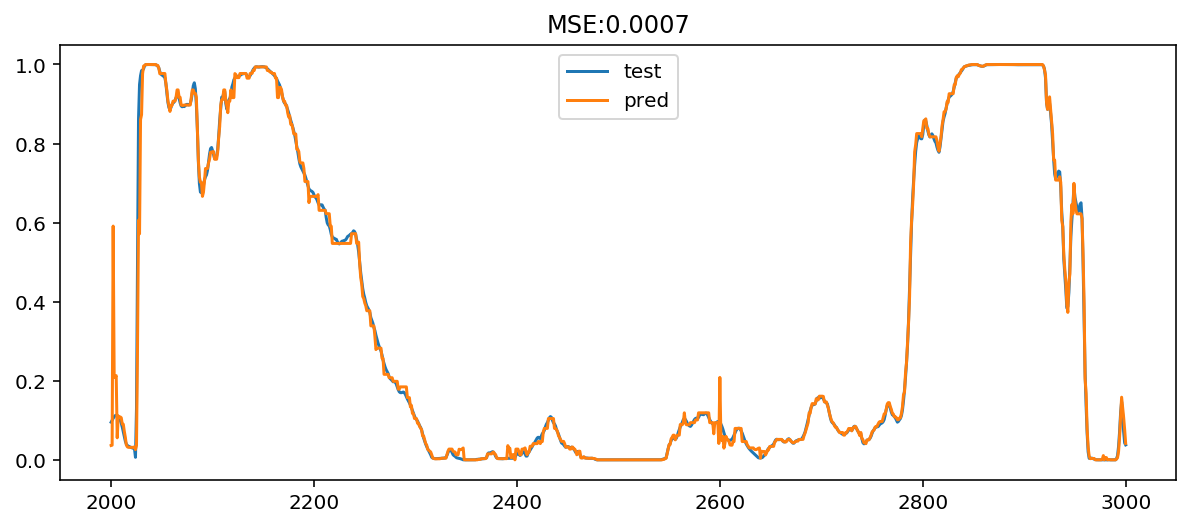

In [32]:
best_param2 = {
    'drop_else': 1.0, 
    'drop_time': 1.0, 
    'hour_num': 0.0, 
    'max_depth': 17.0, 
    'transform': None} 

best_esn_param = {
    'damping': 0.9,
    'n_components': 1401,
    'n_readout': 3001,
    'weight_scaling': 0.8}

X_train, X_test, Y_train, Y_test, Y_Scaler = get_data2(
    hour_num=int(best_param2['hour_num']), 
    transform=best_param2['transform'], 
    drop_time=bool(best_param2['drop_time']), 
    drop_else=bool(best_param2['drop_else']), 
    scale=True, return_y_scaler=True)

base = esn_decision_tree_learner(
    n_readout=best_esn_param['n_readout'], 
    n_components=best_esn_param['n_components'], 
    damping=best_esn_param['damping'],
    weight_scaling=best_esn_param['weight_scaling'], 
    discard_steps=0, 
    random_state=None, 
    criterion="mse", 
    max_depth=best_param2['max_depth'])

mse_list = []
for i in tqdm(np.arange(0,10)):
    mse = base_model_test(
        base, X_train, X_test, Y_train, Y_test, 
        plot_predict=False, 
        return_y_pred=False, 
        return_mse=True, 
        Y_scaler=None,
        verbose=False)
    mse_list.append(mse)

print('mean mse:', np.mean(mse_list))
base_model_test(base, X_train, X_test, Y_train, Y_test, plot_predict=True)

## grid_search

### input param and  max depth

In [ ]:
param_grid2 = {'transform': [None, 'sin', 'cos', 'sin+cos', 'ws*sin(wd)', 
                            'ws*cos(wd)', 'ws*sin(wd)+ws*cos(wd)'],
              'hour_num': np.arange(0,12),
              'drop_time': [True, False],
              'max_depth': np.arange(1,20)}
mse_df2, best_param2 = tree_grid_search2(param_grid2)
mse_df2.to_csv('mse_df2.csv')

``` Python
get_data2(hour_num=0, transform='None', drop_time=False, drop_esle=True, scale=True)

Data: ['相近8个地点2012年数据', '20738-2012.csv'] 

Input space: Index(['Year', 'Month', 'Day', 'Hour', 'Minute', 'wind_direction',
       'wind_speed'],
      dtype='object')
train index: [3001, 7002] train_len: 4001
test index: [2000, 3001] test_len: 1001
best_param:
 {'drop_else': 1.0, 'drop_time': 1.0, 'hour_num': 0.0, 'max_depth': 17.0, 'mse': 0.0012013624130043329, 'transform': 'None'} 

best_mse: 0.0012013624130043329
```

In [4]:
mse_df2 = pd.read_csv('result/mse_df2.csv')

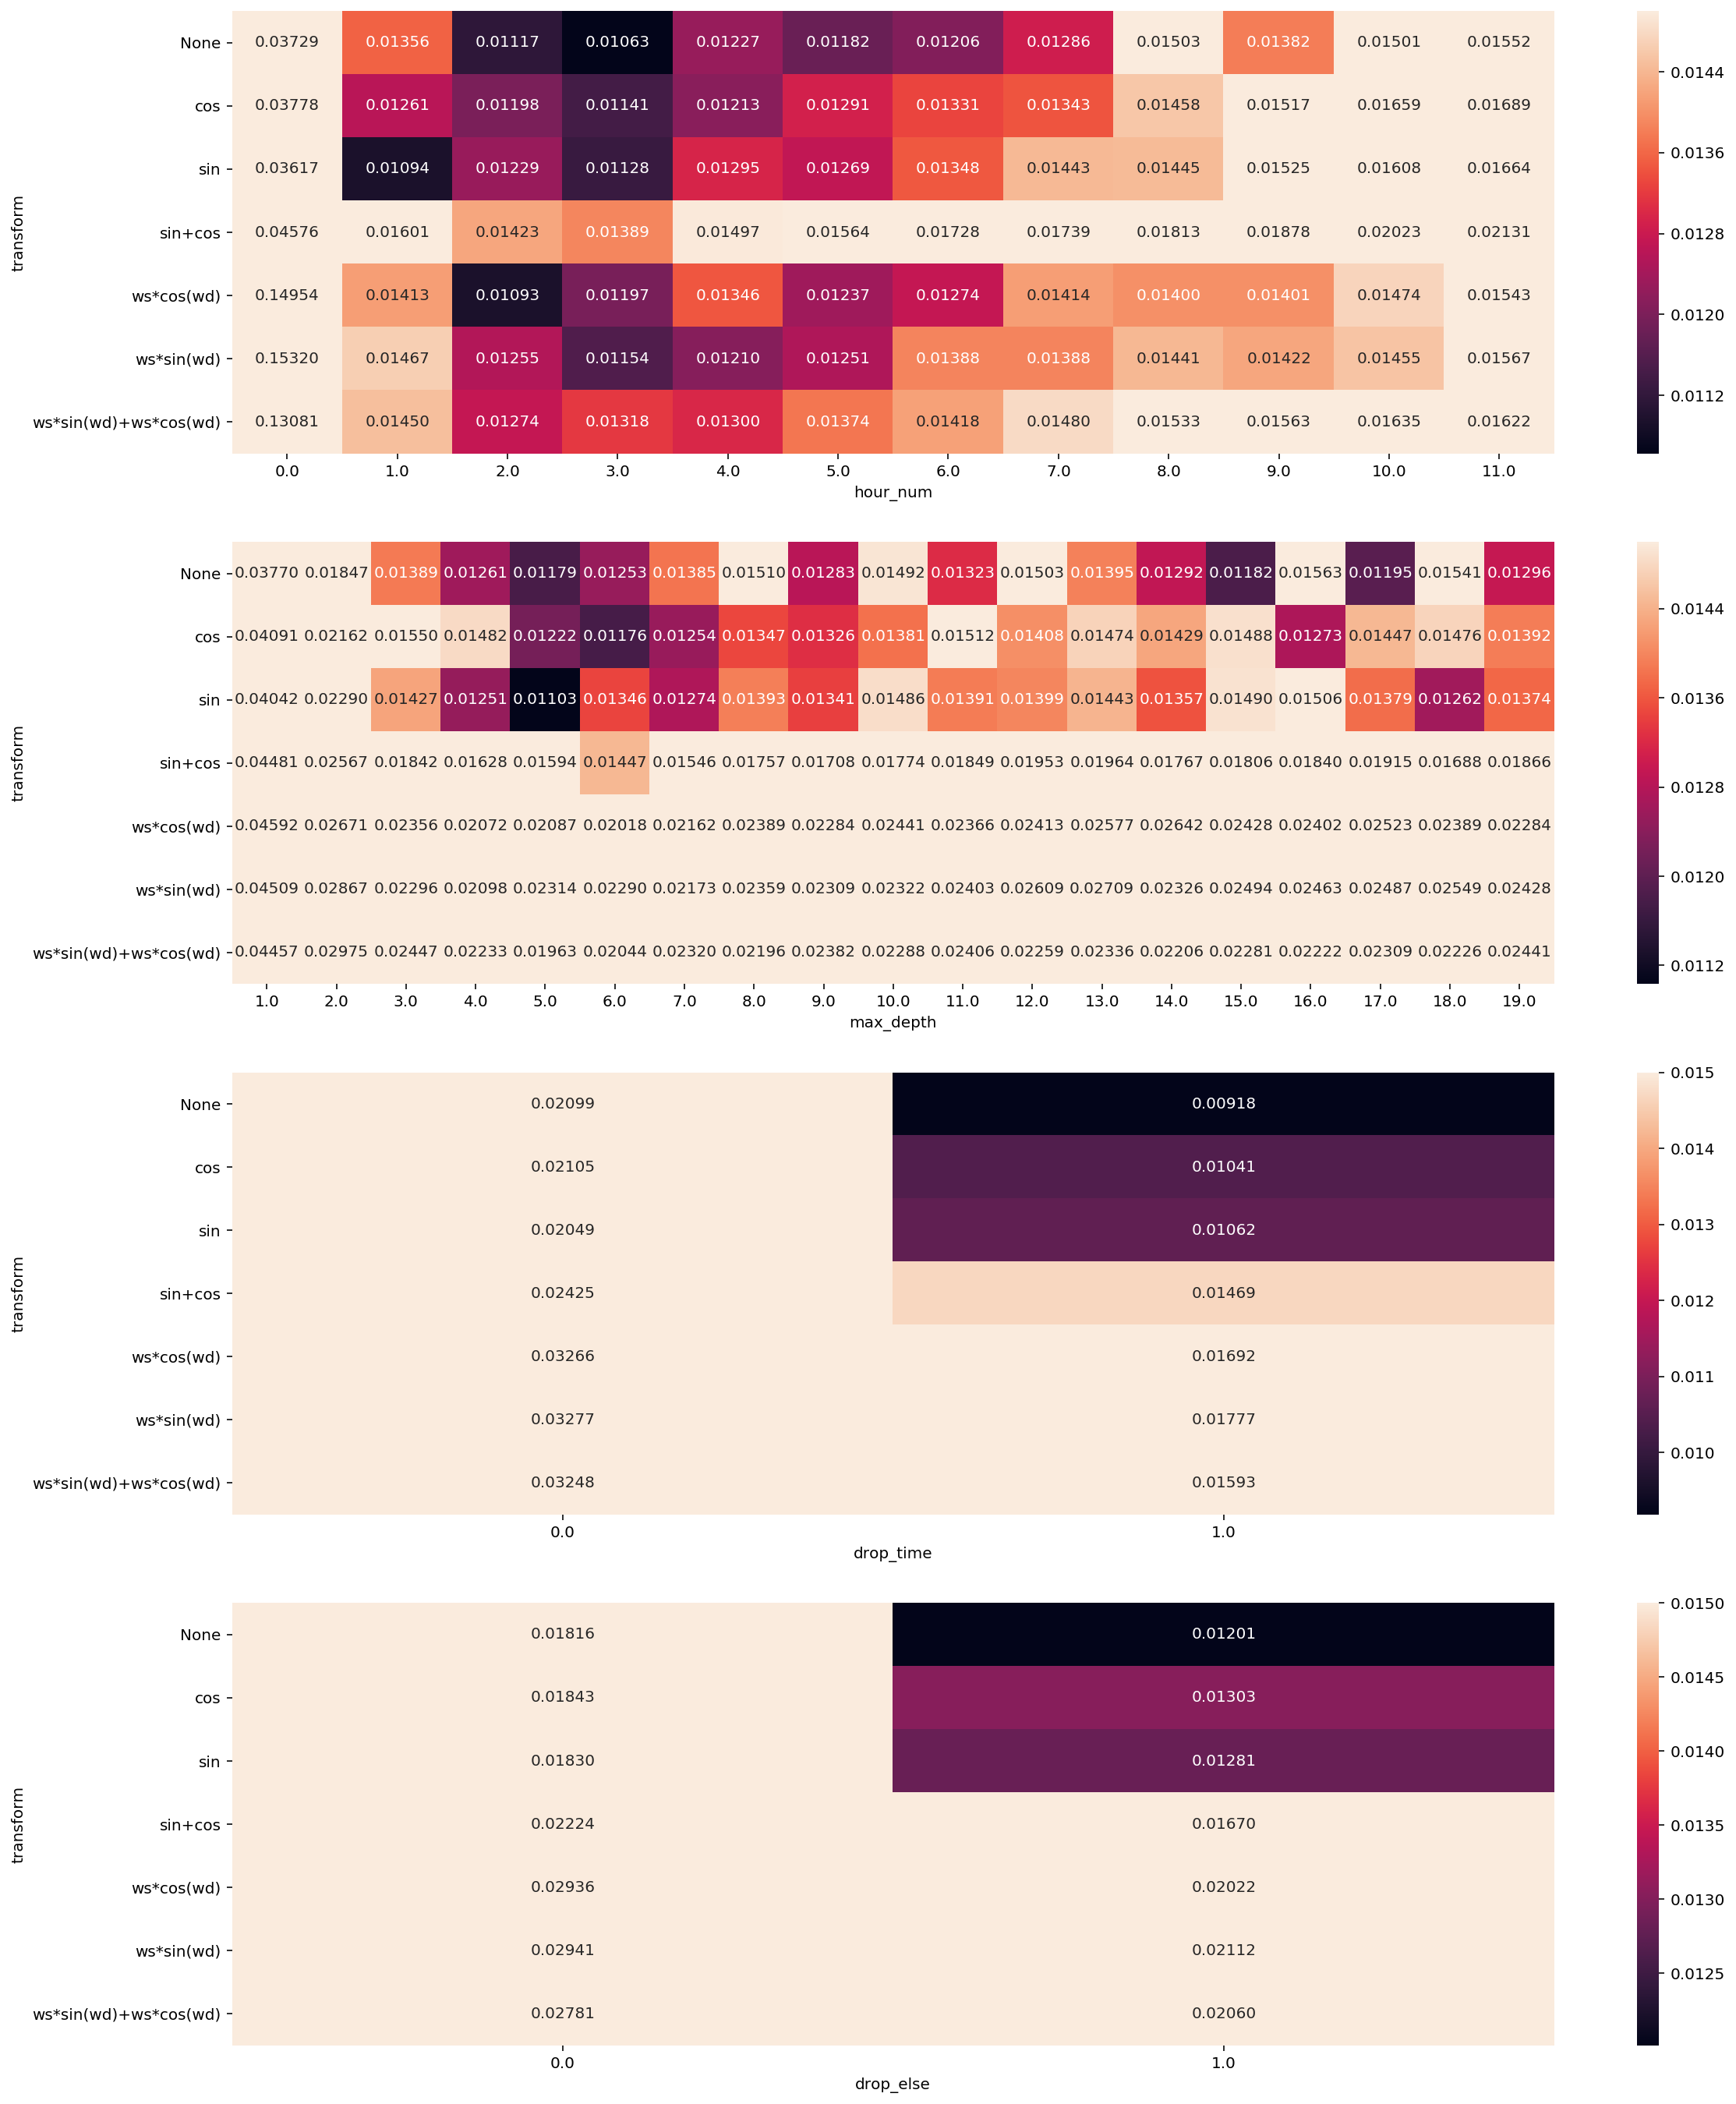

In [14]:
tree_heatmap2(mse_df2, vmax1=0.015, vmax2=0.015, vmax3=0.015, vmax4=0.015)

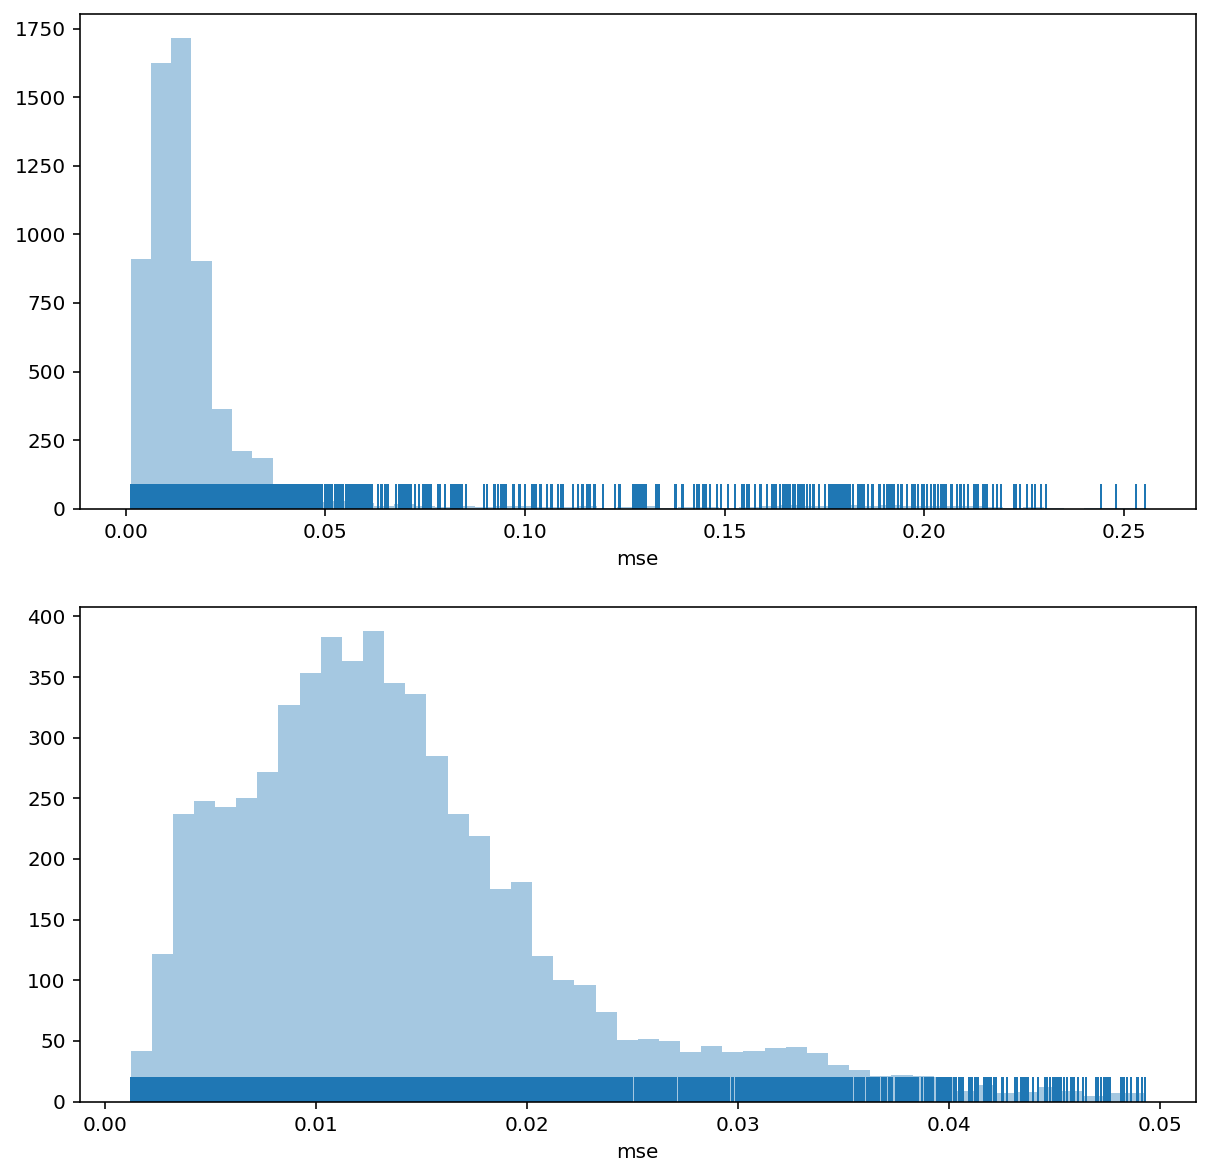

In [12]:
fig, ax = plt.subplots(2,1, figsize=(10,10))
sns.distplot(mse_df2['mse'], kde=False, rug=True, ax=ax[0])
sns.distplot(mse_df2[mse_df2['mse']<0.05]['mse'], kde=False, rug=True, ax=ax[1])

get_data(hour_num=0, transform='None', drop_time=True, drop_esle=True, scale=True)

Data: ['相近8个地点2012年数据', '20738-2012.csv'] 

Input space: Index(['wind_direction', 'wind_speed'], dtype='object')
train index: [3001, 7002] train_len: 4001
test index: [2000, 3001] test_len: 1001


Test MSE 0.0012502561440574285


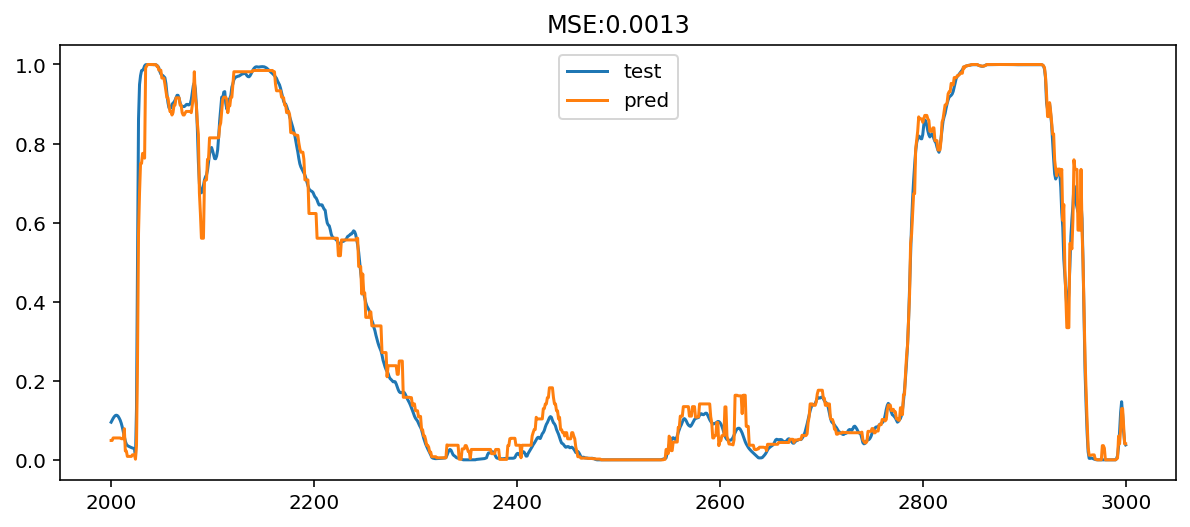

In [34]:
best_param2 = {
    'drop_else': 1.0, 
    'drop_time': 1.0, 
    'hour_num': 0.0, 
    'max_depth': 17.0, 
    'transform': None} 

X_train, X_test, Y_train, Y_test, Y_Scaler = get_data2(
    hour_num=int(best_param2['hour_num']), 
    transform=best_param2['transform'], 
    drop_time=bool(best_param2['drop_time']), 
    drop_else=bool(best_param2['drop_else']), 
    scale=True, return_y_scaler=True)

base = esn_decision_tree_learner(
    discard_steps=0, 
    random_state=None, 
    criterion="mse", 
    max_depth=best_param2['max_depth'])

base_model_test(base, X_train, X_test, Y_train, Y_test, plot_predict=True)

### esn param

In [8]:
best_param2 = {
    'drop_else': 1.0, 
    'drop_time': 1.0, 
    'hour_num': 0.0, 
    'max_depth': 17.0, 
    'transform': None} 
X_train, X_test, Y_train, Y_test, Y_Scaler = get_data2(
    hour_num=int(best_param2['hour_num']), 
    train_index=[6426, 9427], 
    test_index=[14389, 15390], 
    transform=best_param2['transform'], 
    drop_time=bool(best_param2['drop_time']), 
    drop_else=bool(best_param2['drop_else']), 
    scale=True, return_y_scaler=True)

base = esn_decision_tree_learner( 
    discard_steps=0, 
    random_state=None, 
    criterion="mse", 
    max_depth=best_param2['max_depth'])

get_data(hour_num=1, transform='ws*cos(wd)', drop_time=True, scale=True)

Input space: Index(['ws*cos(wd)', 'ws*cos(wd)-1', 'wind_power-1'], dtype='object')
train index: [6426, 9427] train_len: 3000
test index: [14389, 15390] test_len: 1000


In [9]:
esn_param = {
    'n_readout': np.arange(1,10000,1000), 
    'n_components': np.arange(1,2000,100), 
    'damping': np.arange(0,1,0.1),
    'weight_scaling': np.arange(0,1,0.1)}

from sklearn.model_selection import GridSearchCV
from collections import defaultdict
grid_search = GridSearchCV(
    estimator=base, param_grid=esn_param, 
    scoring='neg_mean_squared_error', n_jobs=-1, iid='warn', 
    refit=True, cv=3, verbose=10, 
    return_train_score=True)

In [10]:
grid_search.fit(X_train, Y_train)
esn_grid_search_result2 = pd.DataFrame(grid_search.cv_results_)
esn_grid_search_result2.to_csv('result/esn_grid_search_result2.csv')

Fitting 3 folds for each of 20000 candidates, totalling 60000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   12.6s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   14.6s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   19.6s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   22.4s
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   28.2s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   31.7s
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   35.7s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   38.7s
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   42.8s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   48.5s
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   

[Parallel(n_jobs=-1)]: Done 9105 tasks      | elapsed: 31.4min
[Parallel(n_jobs=-1)]: Done 9240 tasks      | elapsed: 31.8min
[Parallel(n_jobs=-1)]: Done 9377 tasks      | elapsed: 32.2min
[Parallel(n_jobs=-1)]: Done 9514 tasks      | elapsed: 32.6min
[Parallel(n_jobs=-1)]: Done 9653 tasks      | elapsed: 33.1min
[Parallel(n_jobs=-1)]: Done 9792 tasks      | elapsed: 33.5min
[Parallel(n_jobs=-1)]: Done 9933 tasks      | elapsed: 33.9min
[Parallel(n_jobs=-1)]: Done 10074 tasks      | elapsed: 34.4min
[Parallel(n_jobs=-1)]: Done 10217 tasks      | elapsed: 34.9min
[Parallel(n_jobs=-1)]: Done 10360 tasks      | elapsed: 35.3min
[Parallel(n_jobs=-1)]: Done 10505 tasks      | elapsed: 35.7min
[Parallel(n_jobs=-1)]: Done 10650 tasks      | elapsed: 36.2min
[Parallel(n_jobs=-1)]: Done 10797 tasks      | elapsed: 36.6min
[Parallel(n_jobs=-1)]: Done 10944 tasks      | elapsed: 37.1min
[Parallel(n_jobs=-1)]: Done 11093 tasks      | elapsed: 37.6min
[Parallel(n_jobs=-1)]: Done 11242 tasks      | 

[Parallel(n_jobs=-1)]: Done 34840 tasks      | elapsed: 103.6min
[Parallel(n_jobs=-1)]: Done 35105 tasks      | elapsed: 104.2min
[Parallel(n_jobs=-1)]: Done 35370 tasks      | elapsed: 104.9min
[Parallel(n_jobs=-1)]: Done 35637 tasks      | elapsed: 105.6min
[Parallel(n_jobs=-1)]: Done 35904 tasks      | elapsed: 106.3min
[Parallel(n_jobs=-1)]: Done 36173 tasks      | elapsed: 107.0min
[Parallel(n_jobs=-1)]: Done 36442 tasks      | elapsed: 107.7min
[Parallel(n_jobs=-1)]: Done 36713 tasks      | elapsed: 108.4min
[Parallel(n_jobs=-1)]: Done 36984 tasks      | elapsed: 109.1min
[Parallel(n_jobs=-1)]: Done 37257 tasks      | elapsed: 109.8min
[Parallel(n_jobs=-1)]: Done 37530 tasks      | elapsed: 110.5min
[Parallel(n_jobs=-1)]: Done 37805 tasks      | elapsed: 111.2min
[Parallel(n_jobs=-1)]: Done 38080 tasks      | elapsed: 111.9min
[Parallel(n_jobs=-1)]: Done 38357 tasks      | elapsed: 112.6min
[Parallel(n_jobs=-1)]: Done 38634 tasks      | elapsed: 113.3min
[Parallel(n_jobs=-1)]: Do

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=<ngboost.esn_learners.ESN_decision_tree_learner object at 0x1a21e99ba8>,
             iid='warn', n_jobs=-1,
             param_grid={'damping': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
                         'n_components': array([   1,  101,  201,  301,  401,  501,  601,  701,  801,  901, 1001,
       1101, 1201, 1301, 1401, 1501, 1601, 1701, 1801, 1901]),
                         'n_readout': array([   1, 1001, 2001, 3001, 4001, 5001, 6001, 7001, 8001, 9001]),
                         'weight_scaling': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='neg_mean_squared_error', verbose=10)

In [16]:
esn_grid_search_result2 = pd.read_csv('result/esn_grid_search_result2.csv')

In [20]:
esn_grid_search_result2['mean_test_score'] = -esn_grid_search_result2['mean_test_score']

In [25]:
esn_grid_search_result2.iloc[esn_grid_search_result2['mean_test_score'].\
                             idxmin()]

Unnamed: 0                                                          19438
mean_fit_time                                                    0.271961
std_fit_time                                                   0.00393789
mean_score_time                                                 0.0221065
std_score_time                                                0.000497685
param_damping                                                         0.9
param_n_components                                                   1401
param_n_readout                                                      3001
param_weight_scaling                                                  0.8
params                  {'damping': 0.9, 'n_components': 1401, 'n_read...
split0_test_score                                            -0.000939644
split1_test_score                                             -0.00145408
split2_test_score                                            -0.000591579
mean_test_score                       

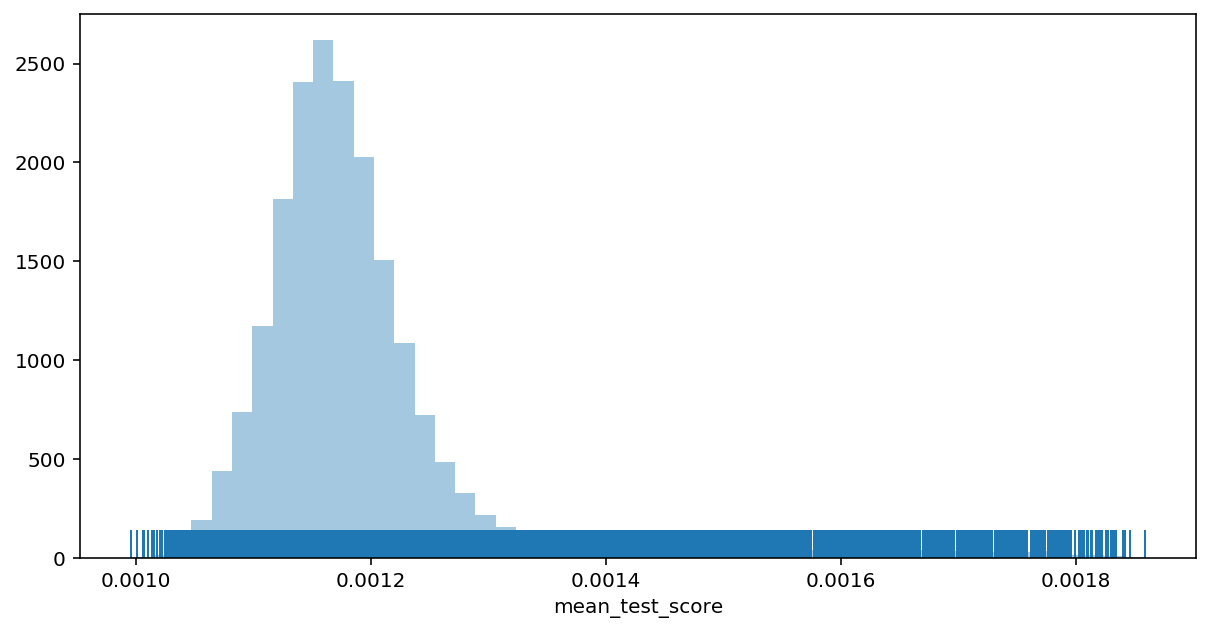

In [26]:
fig, ax = plt.subplots(1,1, figsize=(10,5))
sns.distplot(esn_grid_search_result2['mean_test_score'], kde=False, rug=True, ax=ax)

In [30]:
esn_grid_search_result2[['param_damping','param_weight_scaling']] = \
round(esn_grid_search_result2[['param_damping','param_weight_scaling']], 2)

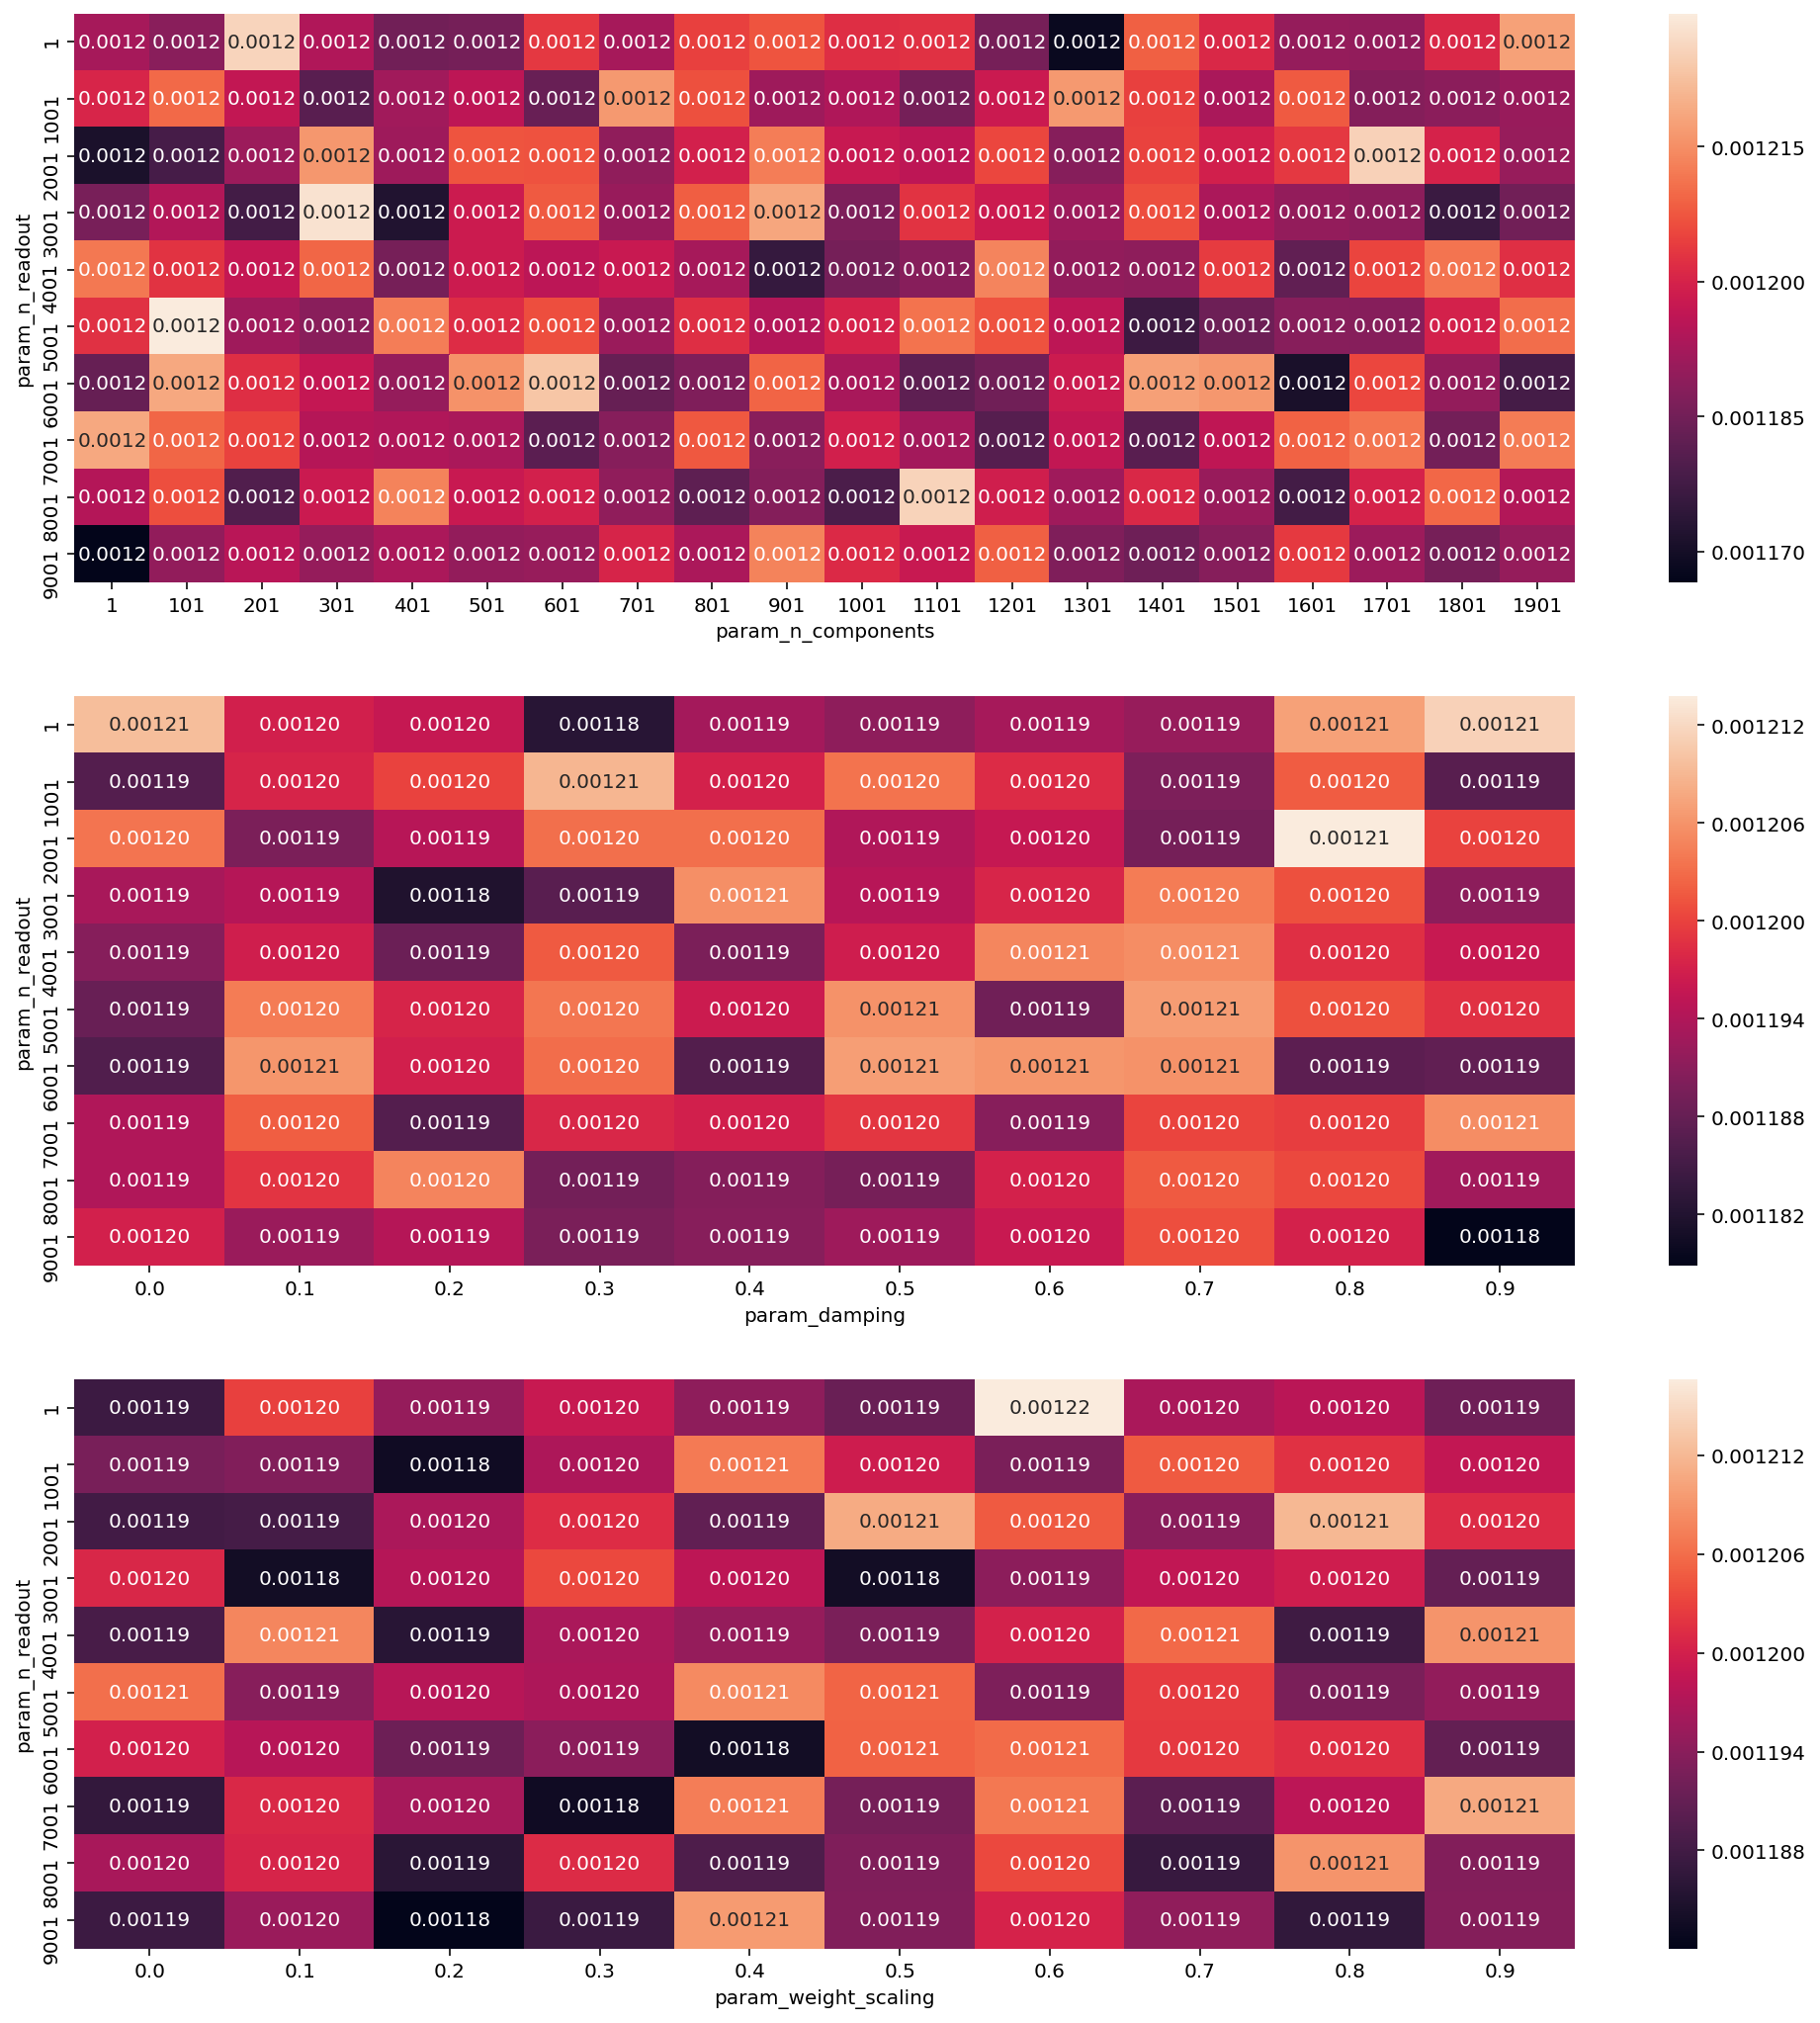

In [31]:
f, ax= plt.subplots(figsize=(17,18),nrows=3)
sns.heatmap(esn_grid_search_result2.groupby(['param_n_readout','param_n_components'])\
            ['mean_test_score'].mean().unstack(),
            ax=ax[0], vmax=None, annot=True, fmt='.4f')
sns.heatmap(esn_grid_search_result2.groupby(['param_n_readout','param_damping'])\
            ['mean_test_score'].mean().unstack(),
            ax=ax[1], vmax=None, annot=True, fmt='.5f')
sns.heatmap(esn_grid_search_result2.groupby(['param_n_readout','param_weight_scaling'])\
            ['mean_test_score'].mean().unstack(),
            ax=ax[2], vmax=None, annot=True, fmt='.5f')